In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## follow the instructions on the website
def unpickle(file):
    ## used to read binary files since our data files are in binary format
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
## loading data from binary data files
batch_1_dictionary = unpickle('cifar-10-batches-py/data_batch_1')
batch_2_dictionary = unpickle('cifar-10-batches-py/data_batch_2')


In [3]:
batch_1_dictionary.keys()


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [4]:
## get training, validation and testing sets
X_train_all = np.array(batch_1_dictionary[b'data']).reshape(10000, 3, 32, 32)
y_train_all = np.array(batch_1_dictionary[b'labels'])
validation_count = 1000
train_count = X_train_all.shape[0] - 1000
X_train = X_train_all[:train_count]
y_train = y_train_all[:train_count]
X_val = X_train_all[train_count:]
y_val = y_train_all[train_count:]
X_test = np.array(batch_2_dictionary[b'data']).reshape(10000, 3, 32, 32)
y_test = np.array(batch_2_dictionary[b'labels'])


In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((9000, 3, 32, 32),
 (9000,),
 (1000, 3, 32, 32),
 (1000,),
 (10000, 3, 32, 32),
 (10000,))

In [6]:
# for RGB data we can simply divide by 255
X_train_normalized = X_train / 255
X_val_normalized = X_val / 255
X_test_normalized = X_test / 255


In [7]:
# here load all classes from new source
metadic = unpickle('cifar-10-batches-py/batches.meta')
CLASSES = list(map(lambda x: x.decode(), metadic[b'label_names']))
print(CLASSES)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
## class label related
# old version of CLASSES not in use
# CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def index_to_class_name(y):
    return CLASSES[y]
def class_name_to_index(class_name):
    return CLASSES.index(class_name)


In [9]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

"""
Plotting utilities, if you want to know how these work exactly, check the reference
Or the documentations
reference: 
https://matplotlib.org/users/image_tutorial.html
https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
"""

def show_single_image(data):
    # show a single image
    ## note that using matplotlib plotting function, we will have to reshape the data as (1,32,32,3)
    img = data.reshape(3, 32, 32).transpose(1, 2, 0)
    imgplot = plt.imshow(img)
def show_multiple_images(data, data_y, n_show=12, columns=4):
    ## given an array of data, show all of them as images
    fig = plt.figure(figsize=(8, 8))
    n = min(data.shape[0], n_show)
    rows = math.ceil(n / columns)
    for i in range(n):
        img = data[i].reshape(3, 32, 32).transpose(1, 2, 0)
        ax = fig.add_subplot(rows, columns, i + 1)  ## subplot index starts from 1 not 0
        class_name = index_to_class_name(data_y[i])
        ax.set_title(str(data_y[i]) + ": " + class_name)
        plt.imshow(img)
    plt.show()


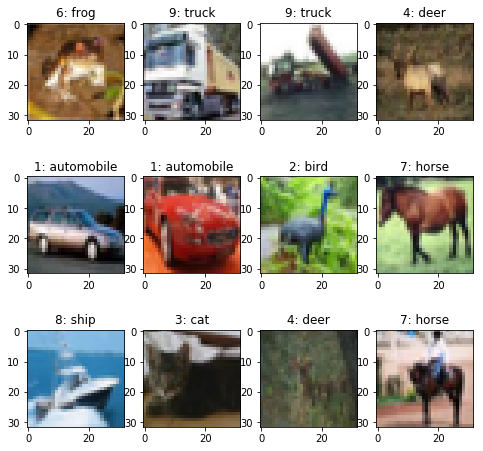

In [12]:
show_multiple_images(X_train, y_train)


In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )  # output of conv1 is 16*16 with 16 layers
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )  # output of conv2 is 8*8 with 32 layers
        self.output = nn.Linear(8*8*32, 10)

    def forward(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        flatten = c2.view(c2.size(0), -1)
        oval = self.output(flatten)
        return oval


In [14]:
# utility for getting prediction accuracy
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _, pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct, correct / n


In [17]:
# init network
conv_net = ConvNet()
print('model structure: ', conv_net)

# init optimizer
learning_rate = 0.25
optimizer = optim.SGD(conv_net.parameters(), lr=learning_rate)

# set loss function
criterion = nn.CrossEntropyLoss()

# prepare for mini-batch stochastic gradient descent
n_iteration = 40
batch_size = 256
n_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_data / batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = torch.Tensor(X_train_normalized)
X_val_tensor = torch.Tensor(X_val_normalized)
X_test_tensor = torch.Tensor(X_test_normalized)

# convert training label to tensor and to type long
y_train_tensor = torch.Tensor(y_train).long()
y_val_tensor = torch.Tensor(y_val).long()
y_test_tensor = torch.Tensor(y_test).long()

print(X_train_tensor.size())
print(y_train_tensor.type())


model structure:  ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Linear(in_features=2048, out_features=10, bias=True)
)


torch.Size([9000, 3, 32, 32])
torch.LongTensor


In [18]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)

for i in range(n_iteration):
    # first get a minibatch of data
    temp_train_loss_list = np.zeros(n_batch)
    temp_train_accu_list = np.zeros(n_batch)
    temp_val_loss_list = np.zeros(n_batch)
    temp_val_accu_list = np.zeros(n_batch)
    for j in range(n_batch):
        batch_start_index = j * batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index + batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index + batch_size]
        y_train_result = conv_net(X_batch)
        y_val_result = conv_net(X_val_tensor)
        _, temp_train_accu = get_correct_and_accuracy(y_train_result, y_batch)
        _, temp_val_accu = get_correct_and_accuracy(y_val_result, y_val_tensor)
        temp_train_loss = criterion(y_train_result, y_batch)
        temp_val_loss = criterion(y_val_result, y_val_tensor)

        temp_train_loss_list[j] = temp_train_loss
        temp_val_loss_list[j] = temp_val_loss
        temp_train_accu_list[j] = temp_train_accu
        temp_val_accu_list[j] = temp_val_accu

        # train step here
        optimizer.zero_grad()
        temp_train_loss.backward()
        optimizer.step()

    ave_train_loss = temp_train_loss_list.mean()
    ave_val_loss = temp_val_loss_list.mean()
    train_accu = temp_train_accu_list.mean()
    val_accu = temp_val_accu_list.mean()
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f"
          % (i, ave_train_loss, train_accu, ave_val_loss, val_accu))

    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = train_accu
    val_loss_list[i] = ave_val_loss
    val_accu_list[i] = val_accu


Iter 0 ,Train loss: 2.264, Train acc: 0.162, Val loss: 2.265, Val acc: 0.159


Iter 1 ,Train loss: 2.197, Train acc: 0.207, Val loss: 2.207, Val acc: 0.202


Iter 2 ,Train loss: 2.187, Train acc: 0.214, Val loss: 2.184, Val acc: 0.222


Iter 3 ,Train loss: 2.036, Train acc: 0.265, Val loss: 2.021, Val acc: 0.269


Iter 4 ,Train loss: 2.058, Train acc: 0.268, Val loss: 2.051, Val acc: 0.266


Iter 5 ,Train loss: 2.045, Train acc: 0.278, Val loss: 2.050, Val acc: 0.275


Iter 6 ,Train loss: 1.873, Train acc: 0.343, Val loss: 1.883, Val acc: 0.333


Iter 7 ,Train loss: 1.780, Train acc: 0.382, Val loss: 1.786, Val acc: 0.362


Iter 8 ,Train loss: 1.700, Train acc: 0.404, Val loss: 1.720, Val acc: 0.388


Iter 9 ,Train loss: 1.638, Train acc: 0.427, Val loss: 1.668, Val acc: 0.409


Iter 10 ,Train loss: 1.573, Train acc: 0.453, Val loss: 1.605, Val acc: 0.431


Iter 11 ,Train loss: 1.507, Train acc: 0.472, Val loss: 1.557, Val acc: 0.444


Iter 12 ,Train loss: 1.460, Train acc: 0.492, Val loss: 1.528, Val acc: 0.455


Iter 13 ,Train loss: 1.416, Train acc: 0.511, Val loss: 1.494, Val acc: 0.465


Iter 14 ,Train loss: 1.376, Train acc: 0.525, Val loss: 1.476, Val acc: 0.471


Iter 15 ,Train loss: 1.381, Train acc: 0.517, Val loss: 1.490, Val acc: 0.464


Iter 16 ,Train loss: 1.314, Train acc: 0.539, Val loss: 1.444, Val acc: 0.477


Iter 17 ,Train loss: 1.268, Train acc: 0.559, Val loss: 1.427, Val acc: 0.485


Iter 18 ,Train loss: 1.263, Train acc: 0.561, Val loss: 1.438, Val acc: 0.484


Iter 19 ,Train loss: 1.240, Train acc: 0.569, Val loss: 1.433, Val acc: 0.488


Iter 20 ,Train loss: 1.203, Train acc: 0.582, Val loss: 1.420, Val acc: 0.494


Iter 21 ,Train loss: 1.182, Train acc: 0.593, Val loss: 1.421, Val acc: 0.495


Iter 22 ,Train loss: 1.161, Train acc: 0.596, Val loss: 1.422, Val acc: 0.495


Iter 23 ,Train loss: 1.130, Train acc: 0.606, Val loss: 1.411, Val acc: 0.503


Iter 24 ,Train loss: 1.112, Train acc: 0.615, Val loss: 1.428, Val acc: 0.498


Iter 25 ,Train loss: 1.103, Train acc: 0.624, Val loss: 1.438, Val acc: 0.498


Iter 26 ,Train loss: 1.058, Train acc: 0.636, Val loss: 1.425, Val acc: 0.504


Iter 27 ,Train loss: 1.057, Train acc: 0.638, Val loss: 1.450, Val acc: 0.501


Iter 28 ,Train loss: 1.020, Train acc: 0.648, Val loss: 1.439, Val acc: 0.507


Iter 29 ,Train loss: 1.017, Train acc: 0.650, Val loss: 1.466, Val acc: 0.502


Iter 30 ,Train loss: 0.977, Train acc: 0.662, Val loss: 1.469, Val acc: 0.507


Iter 31 ,Train loss: 0.975, Train acc: 0.656, Val loss: 1.489, Val acc: 0.501


Iter 32 ,Train loss: 0.950, Train acc: 0.670, Val loss: 1.478, Val acc: 0.508


Iter 33 ,Train loss: 0.928, Train acc: 0.678, Val loss: 1.503, Val acc: 0.507


Iter 34 ,Train loss: 0.946, Train acc: 0.678, Val loss: 1.520, Val acc: 0.504


Iter 35 ,Train loss: 0.883, Train acc: 0.696, Val loss: 1.503, Val acc: 0.511


Iter 36 ,Train loss: 0.876, Train acc: 0.695, Val loss: 1.539, Val acc: 0.507


Iter 37 ,Train loss: 0.889, Train acc: 0.693, Val loss: 1.560, Val acc: 0.504


Iter 38 ,Train loss: 0.868, Train acc: 0.698, Val loss: 1.564, Val acc: 0.506


Iter 39 ,Train loss: 0.832, Train acc: 0.710, Val loss: 1.582, Val acc: 0.510


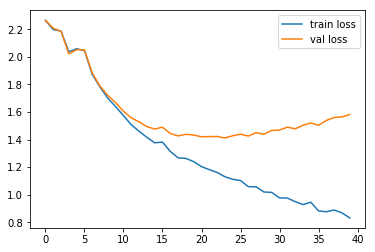

In [19]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()


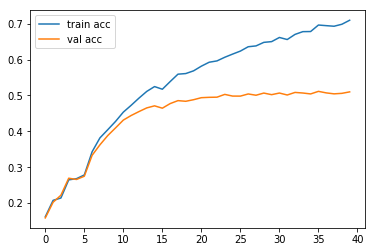

In [20]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()


In [22]:
## test performance on the test set and report final performance
_, test_accu = get_correct_and_accuracy(conv_net(X_test_tensor), y_test_tensor)
print("Test accuracy: ", test_accu)


Test accuracy:  0.5168
